/home/kraftb/.conda/envs/machflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Best run:  LSTM-staticall_allbasins_sqrttrans


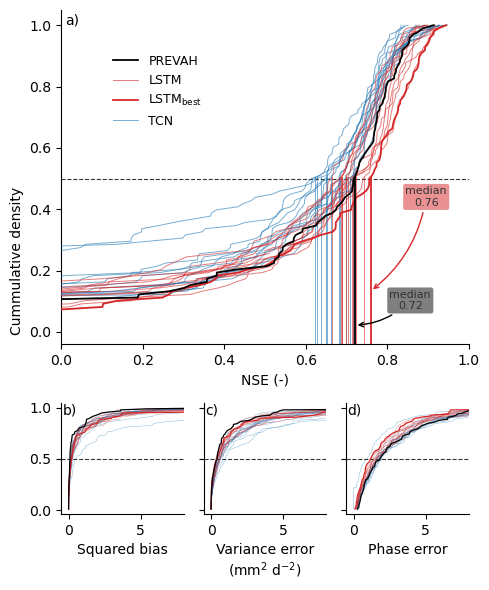

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import optuna
import numpy as np
from scipy.linalg import lstsq
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.ticker as plticker
from matplotlib.colors import Normalize
import matplotlib.patheffects as pe

from utils.data import load_config_xval_test_set
from utils.analysis import xval_station_metrics, get_cdf
from utils.plotting import load_default_mpl_config, savefig
from utils.metrics import compute_metrics
from utils.shapefiles import get_shapefile


load_default_mpl_config()

PLOT_PATH = Path('/net/argon/landclim/kraftb/machflow/mach-flow/analysis/figures/')
RUNS_PATH = Path('/net/argon/landclim/kraftb/machflow/runs/')
runoff_vars = ['Qmm', 'Qmm_mod', 'Qmm_prevah']


def merged_df(mod, prevah):
    x_mod = mod.to_dataframe().reset_index()
    x_mod['source'] = 'mod'
    x_pre = prevah.expand_dims(dummy=1).to_dataframe().reset_index().drop(columns=['dummy'])
    x_pre['model'] = 'PREVAH'
    x_pre['source'] = 'prevah'
    x_both = pd.concat((x_mod, x_pre)).reset_index()

    return x_both

xval_ds = xval_station_metrics(
    RUNS_PATH,
    metrics=['nse', 'bias2', 'varerr', 'phaseerr'],
    time_slices=['1995,1999', '2016,2020'])

best_run = xval_ds.nse.median('station').argmax().compute()
best_run = xval_ds.run.isel(run=best_run).item()

print('Best run: ', best_run)

def run2label(run: str) -> str:

    config_names = []

    # Handle defaults.
    if 'static' not in run:
        config_names.append(r'S$_\mathrm{area}$')

    if 'allbasins' not in run:
        config_names.append(r'C$_\mathrm{98}$')

    if 'sqrttrans' not in run:
        config_names.append(r'T$_\mathrm{none}$')

    # Handle configs.
    PROPERTY2NAME = dict(
        staticall=r'S$_\mathrm{all}$',
        staticdred=r'S$_\mathrm{PCA}$',
        allbasins=r'C$_\mathrm{267}$',
        sqrttrans=r'T$_\mathrm{sqrt}$'
    )

    model, config = run.split('-')
    config_parts = config.split('_')


    for config_part in config_parts:
        config_names.append(PROPERTY2NAME.get(config_part, 'undefined'))

    config_name = ', '.join(config_names)

    return f'{model} ({config_name})'


class ModelColors(object):
    def __init__(self, cmap: str = 'tab10'):
        self.cmap = plt.get_cmap(cmap)
        self.i = 0

    def __next__(self) -> tuple:
        color = self.cmap(self.i)
        self.i += 1
        return color

metrics = list(xval_ds.data_vars)
num_metrics = len(metrics)
ref = 'prevah'

fig = plt.figure(tight_layout=True, figsize=(5, 6))
gs = gridspec.GridSpec(2, 3, height_ratios=[3, 1])

for i, metric in enumerate(metrics):

    if i == 0:
        ax = fig.add_subplot(gs[0, :])
    else:
        ax = fig.add_subplot(gs[1, i - 1])
        ax.set_xlim(-0.5, 8)

    da = xval_ds[metric]
    rel_metrics = da - da.sel(run=ref)
    lstm_colors = ModelColors(cmap='Paired')
    tcn_colors = ModelColors(cmap='Paired')

    for run in da.run.values:

        if run == ref:
            col = 'k'
            style = '-'
            zorder = 10
            lw = 1.3
            alpha = 1
            add_annot = 10
            label = 'PREVAH'
        else:
            zorder = 8
            lw = 0.7
            alpha = 0.6
            add_annot = 0
            if run.startswith('TCN'):
                # col = next(tcn_colors)
                # style = ':'
                col = 'tab:blue'
                style = '-'
                label = 'TCN'
            else:
                # col = next(lstm_colors)
                # style = '--'
                col = 'tab:red'
                style = '-'
                label = 'LSTM'

            if run == best_run:
                # col = 'tab:green'
                alpha = 1
                lw = 1.3
                zorder = 9
                add_annot = 60
                label = r'LSTM$_\mathrm{best}$'
                # label = f'CHRUN (best): {run2label(run)}'

        if i > 0:
            lw = lw - 0.4

        # CDF plots
        # ----------------
        # ax = axes[0, i]
        ax.spines[['right', 'top']].set_visible(False)
        ax.set_xlabel(metric)

        bins, cdf, xloc = get_cdf(da.sel(run=run))

        ax.plot(bins, cdf, label=label, color=col, alpha=alpha, lw=lw, zorder=zorder,
                ls=style)

        if i == 0:
            ax.axvline(xloc, ymin=0, ymax=0.5, color=col, ls=style, alpha=alpha, lw=lw, zorder=zorder)

        if metric in ['nse', 'kge']:
            ax.set_xlim(0, 1)
        elif metric == 'absbias':
            ax.set_xlim(0, 2)

        annot_kwargs = dict(
            textcoords='offset points', ha='center', va='bottom', color='0.2',
            fontsize=8
        )

        if add_annot and i == 0:
            ax.annotate(
                f'median\n{xloc:0.2f}', xy=(xloc, add_annot / 450),
                xytext=(40,add_annot),
                bbox=dict(boxstyle='round,pad=0.2', fc=col, ec='none', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.2', color=col, alpha=1.0),
                zorder=zorder,
                **annot_kwargs)

        if metric == 'nse':
            mname = 'NSE (-)'
        elif metric == 'bias2':
            mname = 'Squared bias'
        elif metric == 'varerr':
            mname = 'Variance error\n(mm$^2$ d$^{-2}$)'
        elif metric == 'phaseerr':
            mname = 'Phase error'
        else:
            mname = 'not defined (-)'
        ax.set_xlabel(mname)

    ax.axhline(0.5, color='0.2', ls='--', alpha=1.0, lw=0.8, zorder=0)

    if i == 0:
        ax.set_ylabel('Cummulative density', y=0.25)

        handles, labels = ax.get_legend_handles_labels()
        handle_list, label_list = [], []
        order = [1, 2, 3, 0]
        # order = [1, 2, 0]
        # order = [0, 1]
        for handle, label in zip(handles, labels):
            if label not in label_list:
                handle_list.append(handle)
                label_list.append(label)
        ax.legend(
            [handle_list[idx] for idx in order],
            [label_list[idx] for idx in order],
            frameon=False,
            fontsize=9,
            loc='upper left',
            bbox_to_anchor=(0.1, 0.9))

    if i > 1:
        ax.set_yticklabels([])

    ax.text(0.01, 0.99, ['a)', 'b)', 'c)', 'd)'][i], va='top', ha='left', transform=ax.transAxes)

# savefig(fig, path=PLOT_PATH / 'fig04.png')



In [2]:
obs, obs_point = get_shapefile(source='obs', datapath='/net/argon/landclim/kraftb/machflow/data')
obs = obs.set_index('OID')
obs_point = obs_point.set_index('OID')

obs = obs.loc[xval_ds.station]
obs_point = obs_point.loc[xval_ds.station]
prevah, _ = get_shapefile(source='prevah', datapath='/net/argon/landclim/kraftb/machflow/data')

for var in xval_ds.data_vars:
    obs_point[var] = xval_ds[var].sel(run='LSTM-staticdred_allbasins_sqrttrans')
    obs_point[var + '_prevah'] = xval_ds[var].sel(run='prevah')
    obs_point[var + '_d'] = obs_point[var] - obs_point[var + '_prevah']

ERROR 1: PROJ: proj_create_from_database: Open of /home/kraftb/.conda/envs/machflow/share/proj failed


In [3]:
xval_ds

<xarray.Dataset> Size: 46kB
Dimensions:   (run: 25, station: 98)
Coordinates:
  * station   (station) <U9 4kB 'CHFO-0098' 'CHFO-0105' ... 'CHFO-0250'
  * run       (run) <U35 4kB 'TCN-sqrttrans' 'prevah' ... 'LSTM-staticall'
Data variables:
    nse       (run, station) float32 10kB 0.699 0.6966 0.5506 ... 0.6906 0.7927
    bias2     (run, station) float32 10kB 4.687e-06 3.421 ... 0.02406 0.1618
    varerr    (run, station) float32 10kB 0.0005334 14.35 ... 0.1 0.02278
    phaseerr  (run, station) float32 10kB 1.456 5.725 1.55 ... 1.581 1.6 1.577

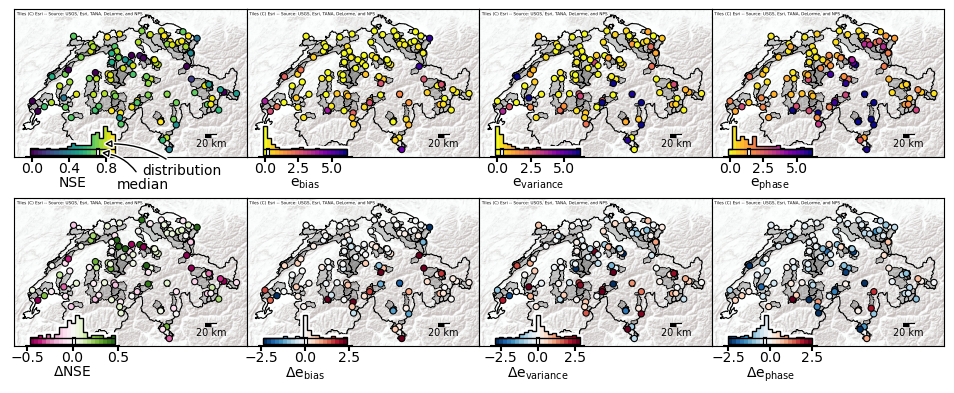

In [457]:
import contextily as cx
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as plticker
from matplotlib.colors import Normalize
import matplotlib.patheffects as pe


fig, axes = plt.subplots(2, 4, figsize=(12, 4.5), gridspec_kw={'wspace': 0})
nbins = 21

for i in range(2):
    for j, (ax, var, label) in enumerate(zip(
            axes[i, :],
            ['nse', 'bias2', 'varerr', 'phaseerr'],
            ['NSE', 'e$_\mathrm{bias}$', 'e$_\mathrm{variance}$', 'e$_\mathrm{phase}$'])):
        if (i > 0) or (j > 0):
            pass
        ax.plot(*prevah.unary_union.buffer(100).geoms[0].exterior.xy, color='k', zorder=0, lw=0.8)
        ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
        ax.margins(0.04)

        ax.plot([780000, 800000], [100000, 100000], color='k', solid_capstyle='butt', lw=3)
        ax.plot([790000, 799500], [100000, 100000], color='w', solid_capstyle='butt', lw=2)
        ax.text(790000, 96000, '20 km', va='top', ha='center', size=7)

        ax = obs.plot(
            ax=ax,
            legend=False,
            facecolor='k',
            edgecolor='none',
            alpha=0.2,
        )

        ax = obs.plot(
            ax=ax,
            legend=False,
            facecolor='none',
            edgecolor='k',
            lw=0.5,
        )

        cx.add_basemap(ax, source='Esri.WorldTerrain', crs=prevah.crs, zoom=9, zorder=-10, attribution_size=3)
        txt = ax.texts[-1]
        txt.set_position([0.01,0.98])
        txt.set_ha('left')
        txt.set_va('top')


        if i == 0:
            varname = var
            data = obs_point[var]
            vmin = 0
            vmax = data.quantile(0.95)
            if j == 0:
                cmap = 'viridis'
                loc = plticker.MultipleLocator(base=0.4)
            else:
                cmap = 'plasma_r'
                vmin = 0
                vmax = 6
                loc = plticker.MultipleLocator(base=2.5)

            label_ = label

        else:
            varname = var + '_d'
            data = obs_point[varname]
            vmin, vmax = data.quantile([0.05, 0.95])
            vabs = max(-vmin, vmax)
            vmin = -vabs
            vmax = vabs

            if j == 0:
                cmap = 'PiYG'
            else:
                cmap = 'RdBu_r'

            label_ = '$\Delta$' + label

        obs_point.plot(
            column=varname,
            legend=False,
            ax=ax,
            zorder=1,
            vmin=vmin,
            vmax=vmax,
            s=20,
            edgecolor='k',
            cmap=cmap,
            lw=0.8)

        # ax_inset = ax.inset_axes([0.05, 1, 0.4, 0.15])
        ax_inset = ax.inset_axes([0.05, 0, 0.4, 0.22])
        ax_inset.set_facecolor('none')

        # x = np.random.uniform(vmin, vmax, 1000)
        x = obs_point[varname]
        extra = (vmax - vmin) / (nbins - 1) / 2
        bins_bounds = np.linspace(vmin - extra, vmax + extra, nbins + 1)
        bin_values, bins = np.histogram(x, bins=bins_bounds)
        bin_centers = (bins_bounds[:-1] + bins_bounds[1:]) / 2
        bin_width = bin_centers[1] - bin_centers[0]

        cmap = mpl.colormaps[cmap]
        norm = Normalize(vmin=vmin, vmax=vmax)
        colors = cmap(norm(bin_centers))
        ax_inset.hist(x, bins_bounds, histtype='step', color='w', lw=4, zorder=-5)
        ax_inset.hist(x, bins_bounds, histtype='step', color='k', lw=1)
        ax_inset.bar(bin_centers, bin_values, bin_width, color=colors)
        ax_inset.set_yticks([])
        ax_inset.set_yticklabels([])
        ax_inset.spines[['left', 'top', 'right']].set_visible(False)
        ax_inset.spines['bottom'].set_linewidth(1.5)
        ax_inset.tick_params(axis='x', which='major', pad=0., width=1.5)

        mx = 0
        mn = -bin_values.max() / 4
        bs = bins_bounds[-1] - bins_bounds[0]
        ax_inset.bar(bin_centers, mn, bin_width, color=colors)
        ax_inset.add_patch(
            Rectangle((bins_bounds[0], 0), bs, mn, ec='w', fc='none', lw=4, zorder=-5))
        ax_inset.add_patch(
            Rectangle((bins_bounds[0], 0), bs, mn, ec='k', fc='none', lw=1))
        ax_inset.set_xlabel(label_, labelpad=0.)

        #ax_inset.axvline(x.median(), color='k', lw=1.8)
        #ax_inset.axvline(x.median(), color='w', lw=0.4, ymin=0.04, ymax=0.96)
        median = x.median()
        ms = (mx - mn) * 0.1
        ax_inset.plot([median, median], [mn + ms, mx - ms], color='k', lw=3)
        ax_inset.plot([median, median], [mn + ms * 2, mx - ms * 2], color='w', lw=1.3)

        if i == 0:
            ax_inset.xaxis.set_major_locator(loc)

            if j == 0:
                ax_inset.annotate('median', 
                    xy=(median + bs * 0.015, (mx + mn) / 2), xycoords='data', color='black',
                    xytext=(bs * 1., mn * 6.5), textcoords='data',
                    arrowprops=dict(arrowstyle='-|>',
                                    connectionstyle='arc3,rad=0.3',
                                    path_effects=[pe.withStroke(linewidth=3, foreground='w')],
                                    fc='w'))

                ax_inset.annotate('distribution', 
                    xy=(median + bs * 0.05, mx + 9 * ms), xycoords='data', color='black',
                    xytext=(bs * 1.3, mn * 4.2), textcoords='data',
                    arrowprops=dict(arrowstyle='-|>',
                                    connectionstyle='arc3,rad=0.2',
                                    path_effects=[pe.withStroke(linewidth=3, foreground='w')],
                                    fc='w'))